# Supernova distances and redshifts (part 2)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

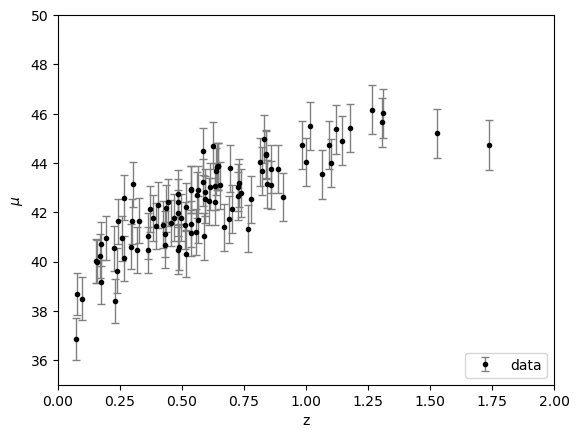

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### GPR

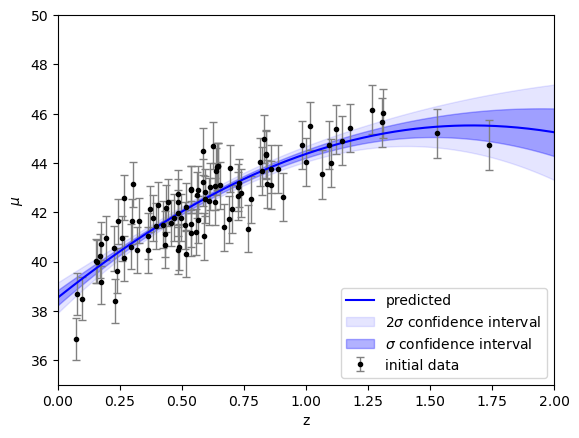

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

x = np.linspace(0,2,500)[:,None]
X = z_sample.reshape((len(z_sample),1))
dy = dmu
y = mu_sample

K = ConstantKernel(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))   # kernel
gp = GaussianProcessRegressor(kernel=K, alpha=dy**2)
gp.fit(X,y)
y_pred, dy_pred = gp.predict(x, return_std=True)

# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='initial data')
plt.plot(x, y_pred, c='b',markersize=4, label='predicted')
plt.fill_between(x[:,0], y_pred-2*dy_pred, y_pred+2*dy_pred, color='b', alpha=0.1, label='2$\sigma$ confidence interval')
plt.fill_between(x[:,0], y_pred-dy_pred, y_pred+dy_pred, color='b', alpha=0.3, label='$\sigma$ confidence interval')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

The uncertainty of the regression is high there are few data points, while it shrinks for the central values of z, where there are many. It is very useful to see this variation in the uncertainty, otherwise we could think that the regression function is equally contrained independently on the number of data points we are fitting. 

### True relation

In [4]:
from astropy import constants as const
from astropy.cosmology import Planck18

c = const.c.value /1000         # km / s
H0 = Planck18.H0.value          # km/s/Mpc
omegaM = Planck18.Om0           # omegaL=1-omegaM (flat universe)

print(c)
print(H0)
print(omegaM)

299792.458
67.66
0.30966


In [5]:
nbins = 300
def integral(z, oM, oL):
    I = 0
    dz = (z-0)/nbins
    for i in range(nbins):
        x = 0+dz*i
        I += dz / np.sqrt(oM*(1+x)**3+oL)
    return I
   
def model(z,params):
    H0, omegaM = params
    H0 *= 10**(-6)
    omegaL = 1-omegaM
    return 5*np.log10(c/H0/10*(1+z)*integral(z,omegaM,omegaL))

/tmp/ipykernel_3301/4283576319.py:14: RuntimeWarning: divide by zero encountered in log10
  return 5*np.log10(c/H0/10*(1+z)*integral(z,omegaM,omegaL))


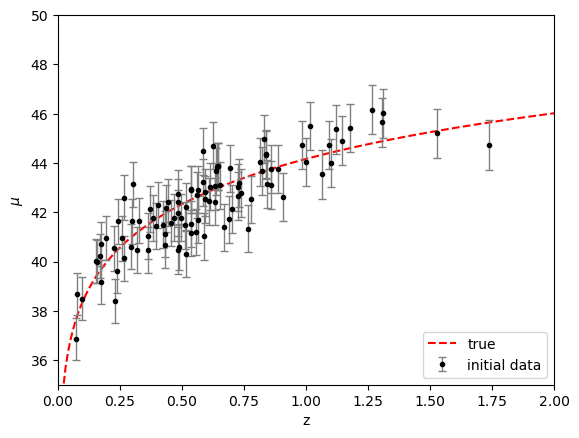

In [6]:
# true relation between mu and z

z_grid = np.linspace(0,2,200)
mu = model(z_grid, [H0, omegaM])

plt.plot(z_grid,mu,'--r',label='true')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='initial data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### MCMC fit to find best values of $H_0$ and $\Omega_M$

In [7]:
import emcee
import scipy.integrate as integrate

x_data = z_sample
y_data = mu_sample
y_uncertainty = dmu

def lnLikelihood(params, x_data, y_data, y_uncertainty):      # gaussian likelihood
    y_pred = model(x_data, params)
    return 0.5*np.nansum((-(y_data - y_pred)**2 / (2 * y_uncertainty**2)))

def lnPrior(params):      # uniform prior
    H0, oM = params
    if 50<H0<90 and 0<oM<1:
        return 0.
    else:
        return -np.inf  
    
def lnPosterior(params, x_data, y_data, y_uncertainty):
    return lnLikelihood(params, x_data, y_data, y_uncertainty) + lnPrior(params)

# Parametri MCMC
ndim = 2  
nwalkers = 10  
burn = 0  
nsteps = 500

# Inizializza i parametri
np.random.seed(0)
starting_guesses = np.random.random((nwalkers,ndim))
starting_guesses[:,0] += 64  # (67,68)
starting_guesses[:,1] += 0   # (0,1)

# Esegui l'MCMC con emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior, args=[x_data, y_data, y_uncertainty])
sampler.run_mcmc(starting_guesses, nsteps)

# Ottieni e ripulisci la catena
emcee_trace = sampler.chain[:, burn:, :].reshape(-1, ndim)

print('Done.')

/tmp/ipykernel_3301/4283576319.py:7: RuntimeWarning: invalid value encountered in sqrt
  I += dz / np.sqrt(oM*(1+x)**3+oL)


Done.


In [3]:
from IPython.display import Audio
from numpy import pi, sin, cos

frequency = 440  # Frequenza del beep
duration = 2     # Durata in secondi

t = np.linspace(0,duration,44100*duration)
#signal = np.sin(2*np.pi*500*t) + np.sin(2*np.pi*512*t)
signal = sin(2*pi*frequency*t) 
beep = Audio(signal, rate=44100, autoplay=True)
beep

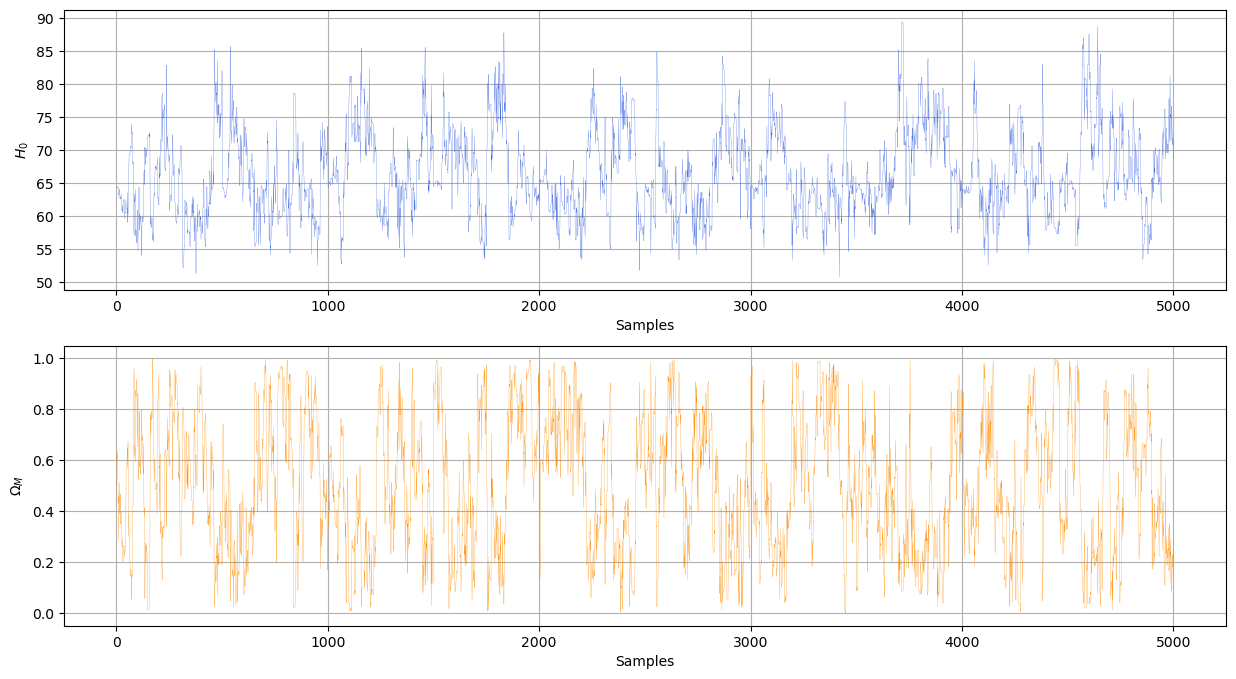

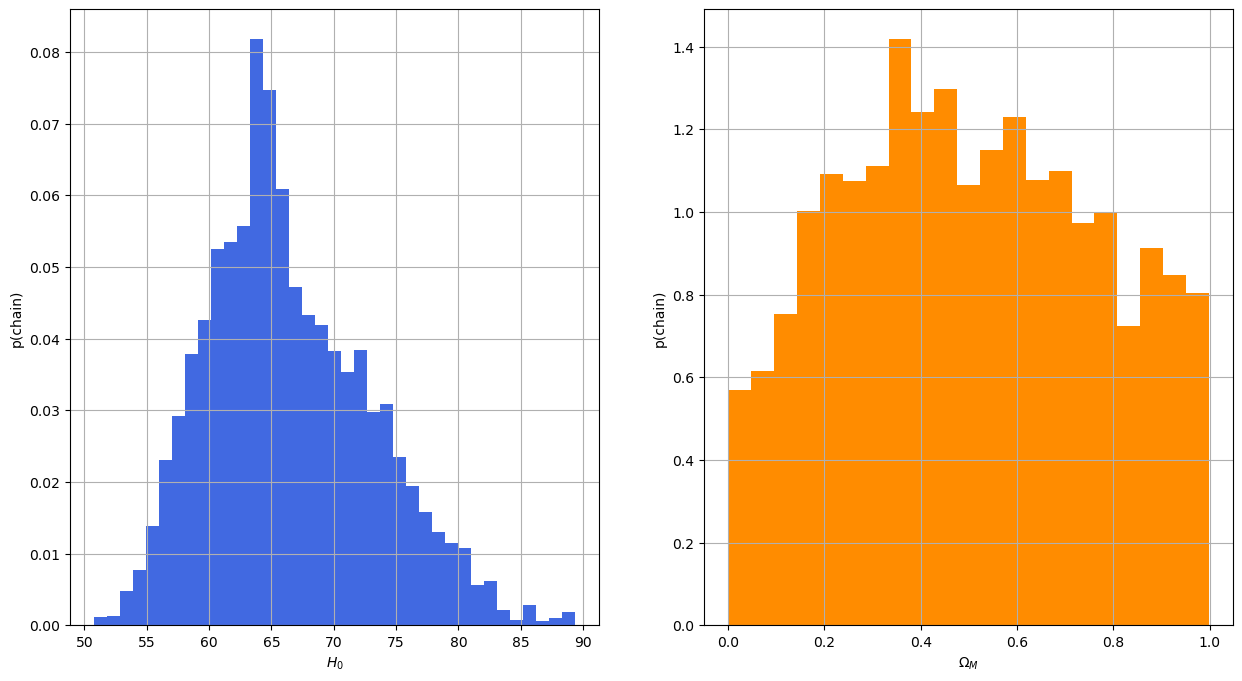

In [8]:
# Plots
labels = ['$H_0$', '$\Omega_M$']
colors = ['royalblue', 'darkorange']
xgrid = np.linspace(1, len(emcee_trace[:]), len(emcee_trace[:]))

# Chain plots
fig = plt.figure(figsize=(15, 8))
for i in range(2):
    ax = fig.add_subplot(2,1,i+1)
    plt.plot(xgrid, emcee_trace[:, i], color=colors[i],linewidth=0.2)  
    plt.grid()
    plt.xlabel('Samples')
    plt.ylabel(labels[i])
plt.show()


# Histograms of the chains
fig = plt.figure(figsize=(15, 8))
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    Nhist, bins, patches = plt.hist(emcee_trace[:, i], bins='auto', histtype='stepfilled', density=True,color=colors[i])
    plt.ylabel('p(chain)')
    plt.xlabel(labels[i])
    plt.grid()
plt.show()

Parameter estimate (median):
Ho = 65.38 km/s/Mpc
Om = 0.49


/tmp/ipykernel_3301/4283576319.py:14: RuntimeWarning: divide by zero encountered in log10
  return 5*np.log10(c/H0/10*(1+z)*integral(z,omegaM,omegaL))


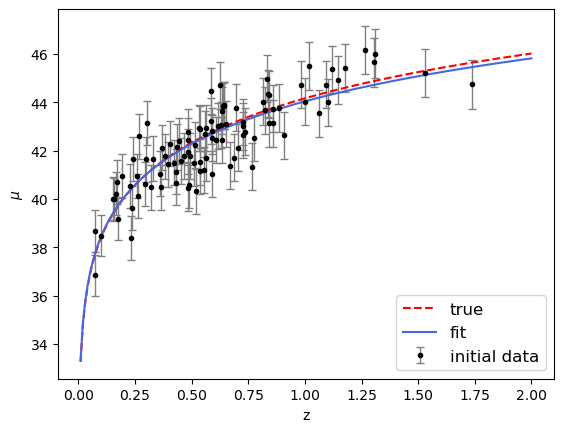

In [9]:
med_params = np.median(emcee_trace, axis=0)
sigma_params = np.std(emcee_trace, axis=0)

print("Parameter estimate (median):")
print('Ho =', round(med_params[0],2),'km/s/Mpc')
print('Om =', round(med_params[1],2))
    
z_grid = np.linspace(0,2,200)
mu_f = model(z_grid,med_params)
    
# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='initial data')
plt.plot(z_grid,mu,'--r',label='true')
plt.plot(z_grid,mu_f,color='royalblue',label='fit')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(fontsize=12)
plt.show()

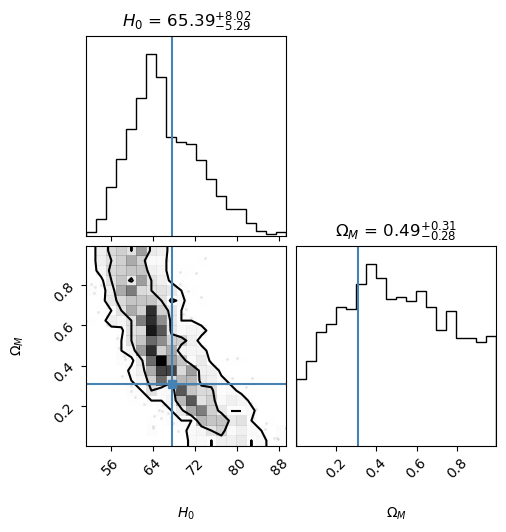

In [11]:
import corner

flat_samples = sampler.get_chain(discard=burn, thin=4, flat=True)

fig = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], show_titles=True, truths=[H0,omegaM])
plt.show()

### MCMC Matter only

In [12]:
import emcee
import numpy as np
oM = 1

x_data = z_sample    
y_data = mu_sample  
y_uncertainty = dmu  

def lnLikelihood(params, x_data, y_data, y_uncertainty):
    H0 = params[0]  
    
    y_pred = model(x_data, [H0, oM]) 
    return -0.5 * np.sum((y_data - y_pred)**2 / (y_uncertainty**2))

def lnPrior(params):
    H0 = params[0]
    if 50 < H0 < 90: 
        return 0.0
    else:
        return -np.inf  

def lnPosterior(params, x_data, y_data, y_uncertainty):
    return lnLikelihood(params, x_data, y_data, y_uncertainty) + lnPrior(params)

ndim = 1 
nwalkers = 10
burn = 0  
nsteps = 1000

np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))
starting_guesses[:, 0] += 64  

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnPosterior, args=[x_data, y_data, y_uncertainty])
sampler.run_mcmc(starting_guesses, nsteps)

emcee_trace = sampler.chain[:, burn:, :].reshape(-1, ndim)

print('Done.')

Done.


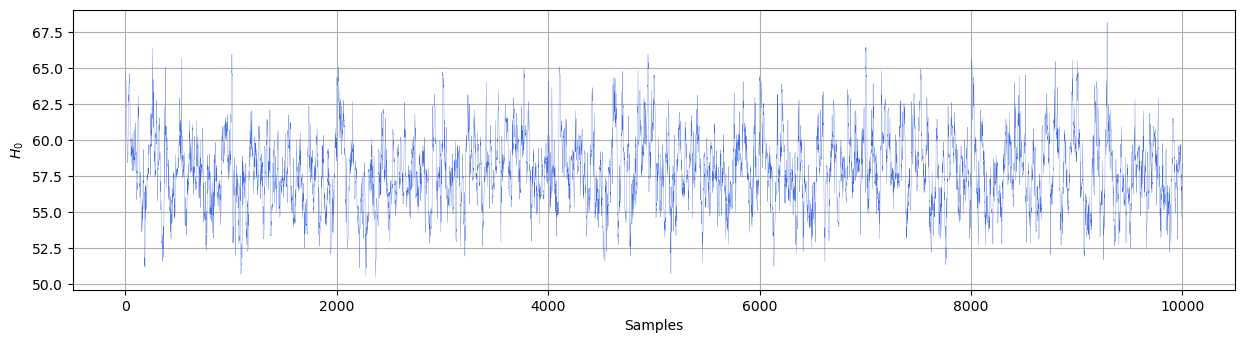

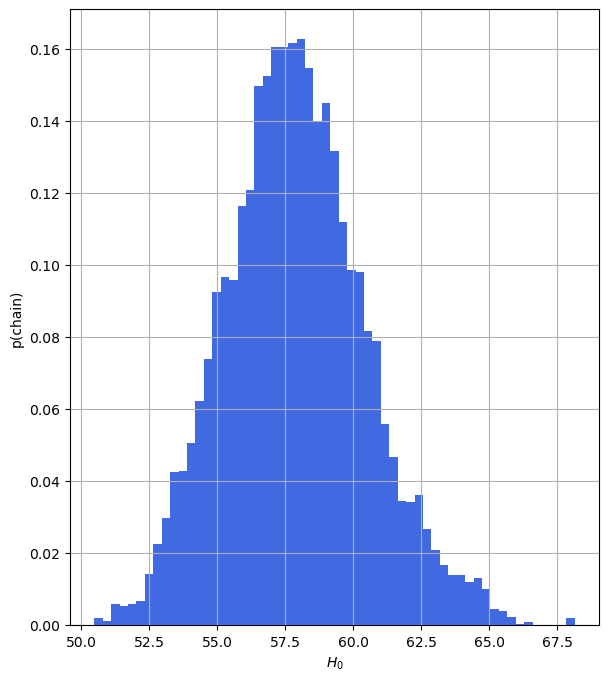

In [13]:
# Plots
labels = ['$H_0$', '$\Omega_M$']
colors = ['royalblue', 'darkorange']
xgrid = np.linspace(1, len(emcee_trace[:]), len(emcee_trace[:]))

# Chain plots
fig = plt.figure(figsize=(15, 8))
for i in range(1):
    ax = fig.add_subplot(2,1,i+1)
    plt.plot(xgrid, emcee_trace[:, i], color=colors[i],linewidth=0.2)  
    plt.grid()
    plt.xlabel('Samples')
    plt.ylabel(labels[i])
plt.show()

# Histograms of the chains
fig = plt.figure(figsize=(15, 8))
for i in range(1):
    ax = fig.add_subplot(1,2,i+1)
    Nhist, bins, patches = plt.hist(emcee_trace[:, i], bins='auto', histtype='stepfilled', density=True,color=colors[i])
    plt.ylabel('p(chain)')
    plt.xlabel(labels[i])
    plt.grid()
plt.show()

Parameter estimate (median):
Ho = 57.79 km/s/Mpc
Om = 1


/tmp/ipykernel_3301/4283576319.py:14: RuntimeWarning: divide by zero encountered in log10
  return 5*np.log10(c/H0/10*(1+z)*integral(z,omegaM,omegaL))


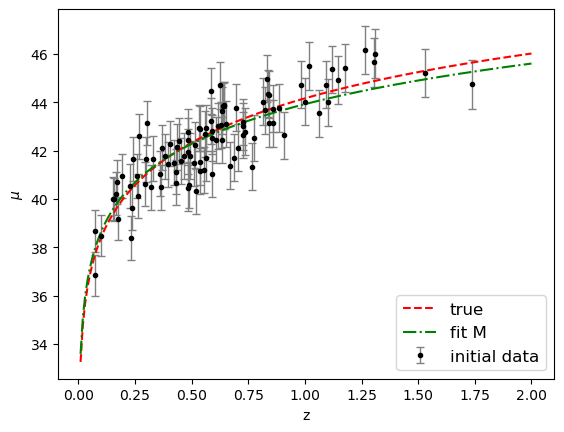

In [14]:
med_params_M = np.median(emcee_trace, axis=0)

print("Parameter estimate (median):")
print('Ho =', round(med_params_M[0],2),'km/s/Mpc')
print('Om =', oM)

z_grid = np.linspace(0,2,200)
mu_m = model(z_grid,[med_params_M[0], oM])

# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, lw=1,label='initial data')
plt.plot(z_grid,mu,'--r',label='true')
plt.plot(z_grid,mu_m,'-.g',label='fit M')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(fontsize=12)
plt.show()

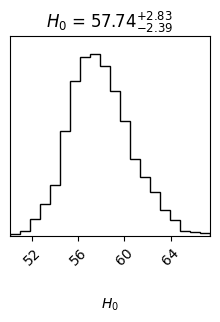

In [15]:
import corner

flat_samples = sampler.get_chain(discard=burn, thin=4, flat=True)

fig = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], show_titles=True)
plt.show()

## Model selection with AIC

AIC for Model 1: -3.3721052766525403
AIC for Model 2: -4.008123937024398
Model 2 (only matter) is preferred.


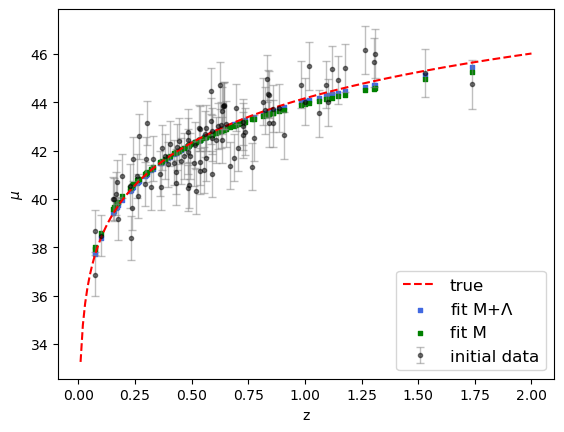

In [15]:
def compute_aic(y_data, y_model, dy_data, k):
    n = len(y_data)  # Number of data points
    residuals = (y_data - y_model) / dy_data  # Residuals normalized by uncertainty
    rss = np.sum(residuals ** 2)  # Residual sum of squares (RSS)
    # Compute AIC
    aic = n * np.log(rss / n) + 2 * k
    return aic

k_model1 = 2  #  MATTER + LAMBDA
k_model2 = 1  #  MATTER ONLY

mu_f = model(z_sample,med_params)
mu_m = model(z_sample,[med_params_M[0], 1])

aic_model1 = compute_aic(mu_sample, mu_f, dmu, k_model1)
aic_model2 = compute_aic(mu_sample, mu_m, dmu, k_model2)

print(f"AIC for Model 1: {aic_model1}")
print(f"AIC for Model 2: {aic_model2}")

if aic_model1 < aic_model2:
    print("Model 1 (matter + lambda) is preferred.")
else:
    print("Model 2 (only matter) is preferred.")
      
# plot
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', capsize=3, alpha=0.5, lw=1,label='initial data')
plt.plot(z_grid,mu,'--r',label='true')
plt.scatter(z_sample,mu_f,marker='s',s=5,color='royalblue',label='fit M+$\Lambda$')
plt.scatter(z_sample,mu_m,marker='s',s=5,color='green',label='fit M')
plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(fontsize=12)
plt.show()

### Model selection with BIC

In [16]:
import numpy as np

# Function to compute BIC
def compute_bic(y_data, y_model, dy_data, k):
    n = len(y_data)  # Number of data points
    residuals = (y_data - y_model) / dy_data  # Residuals normalized by uncertainty
    rss = np.sum(residuals ** 2)  # Residual sum of squares (RSS)
    
    # Compute BIC
    bic = n * np.log(rss / n) + k * np.log(n)
    return bic

k_model1 = 2  #  MATTER + LAMBDA
k_model2 = 1  #  MATTER ONLY

mu_f = model(z_sample, med_params)  
mu_m = model(z_sample, [med_params_M[0], 1])    

bic_model1 = compute_bic(mu_sample, mu_f, dmu, k_model1)
bic_model2 = compute_bic(mu_sample, mu_m, dmu, k_model2)

print(f"BIC for Model 1: {bic_model1}")
print(f"BIC for Model 2: {bic_model2}")

if bic_model1 < bic_model2:
    print("Model 1 (matter + lambda) is preferred.")
else:
    print("Model 2 (only matter) is preferred.")


BIC for Model 1: 1.8382350953236433
BIC for Model 2: -1.4029537510363062
Model 2 (only matter) is preferred.


From a model selection analysis our data seem to contain evidence of dark energy presence. But both from the above plot and the results of AIC and BIC we can say that there is not so much difference between the two models, given our data. Moreover, the true relation z-mu (red dashed line) is closer to the model with dark energy, thus the given data are too few to select any model with significative confidence.

## Cloning data

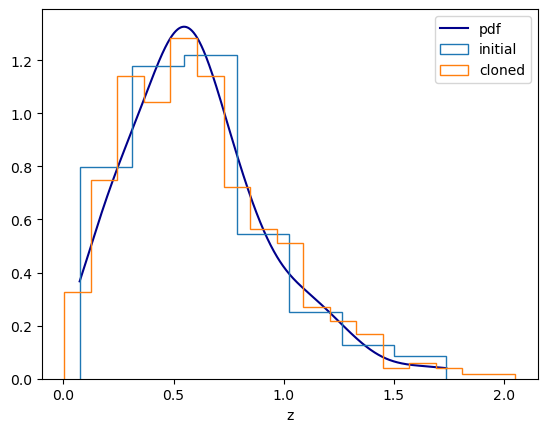

In [22]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(z_sample)  
x_grid = np.linspace(min(z_sample), max(z_sample), 1000)  
pdf = kde(x_grid) 

kde = gaussian_kde(z_sample, bw_method='scott')

Nclon = 1000
z_cl = kde.resample(Nclon)    # cloning z-values following the pdf
z_cloned = z_cl[z_cl>0]

plt.plot(x_grid, pdf, 'darkblue', label='pdf')
plt.hist(z_sample, bins='scott', density=True, histtype='step', label='initial')
plt.hist(z_cloned, bins='scott', density=True, histtype='step', label='cloned')
plt.legend()
plt.xlabel('z')
plt.show()

/tmp/ipykernel_3301/4283576319.py:7: RuntimeWarning: invalid value encountered in sqrt
  I += dz / np.sqrt(oM*(1+x)**3+oL)
/tmp/ipykernel_3301/4283576319.py:7: RuntimeWarning: invalid value encountered in sqrt
  I += dz / np.sqrt(oM*(1+x)**3+oL)
/tmp/ipykernel_3301/4283576319.py:7: RuntimeWarning: invalid value encountered in sqrt
  I += dz / np.sqrt(oM*(1+x)**3+oL)


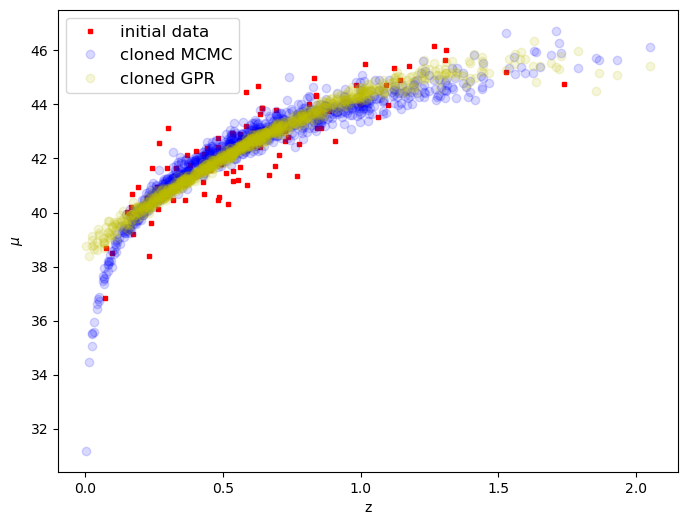

In [23]:
mu_cloned = []
mu_gpr = []

for z in z_cloned:
    params = [np.random.normal(med_params[0],sigma_params[0]), np.random.normal(med_params[1],sigma_params[1])]
    mu_cloned.append( model(z, params) )
    
    mu_fit, sigma = gp.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(mu_fit, sigma))

# plot
fig = plt.figure(figsize=(8,6))
plt.errorbar(z_sample, mu_sample, fmt='sr', markersize=3, capsize=3, alpha=1, lw=1, label='initial data')
plt.errorbar(z_cloned, mu_cloned, fmt='.b', markersize=12, capsize=3, alpha=0.15, lw=1, label='cloned MCMC')
plt.errorbar(z_cloned, mu_gpr,    fmt='.y', markersize=12, capsize=3, alpha=0.15, lw=1, label='cloned GPR')

plt.xlabel('z')
plt.ylabel('$\mu$')
plt.legend(fontsize=12)
plt.show()